## SDXL and IP Adapter pipeline for style transfer

#### Importing libraries and making sure GPU is visible

In [1]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image
import torch

torch.cuda.is_available()

/anaconda/envs/diffusers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Basic SDXL + IP Adapter pipeline

Let's load our model (Stable Diffusion XL) as well as the IP-Adapter that matches our model

In [ ]:
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential
from azure.ai.ml import MLClient

def load_model_from_catalog(model_id, destination_path=None):
    credential = DefaultAzureCredential()

    ml_client_registry = MLClient(credential=credential,
                        registry_name="azureml",
                        registry_location="eastus")
    
    print(f"Downloading model {model_id} to {destination_path if destination_path else 'current directory'}")
    ml_client_registry.models.download(name="stabilityai-stable-diffusion-xl-base-1-0", version=5, download_path=destination_path)
    local_model_path = f"{destination_path if destination_path else '.'}/{model_id}/mlflow_model_folder/artifacts/INPUT_model_path"
    
    return local_model_path



In [ ]:
use_catalog = False

if use_catalog:
    model_path = load_model_from_catalog("stabilityai-stable-diffusion-xl-base-1-0")
    print("downloading model and importing from local path")
else:
    print("importing model from huggingface")
    model_path = "stabilityai/stable-diffusion-xl-base-1.0"

pipeline = AutoPipelineForText2Image.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")

pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.34it/s]
/anaconda/envs/diffusers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/anaconda/envs/diffusers/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


We'll be using sample images as reference, you can replace these by your own. Let's preview one reference image

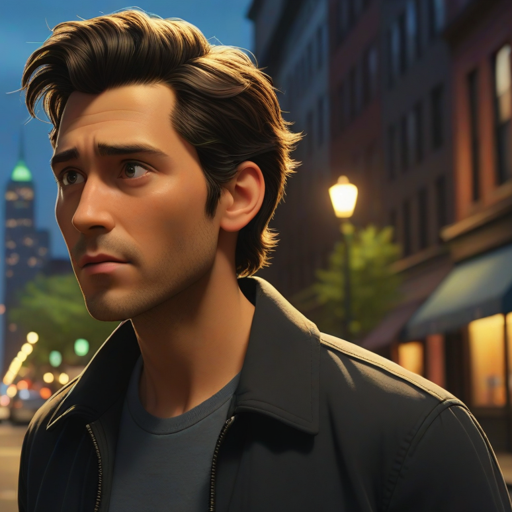

In [3]:
style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_image = load_image(f"{style_folder}/img7.png")

style_image.resize((512,512))

Now let's run the SDXL + IP-Adapter pipeline on the style image. Note the `set_ip_adapter` method. This method controls the amount of text or image conditioning to apply to the model. A value of 1.0 means the model is only conditioned on the image prompt. Lowering this value encourages the model to produce more diverse images, but they may not be as aligned with the image prompt. Typically, a value of 0.5 achieves a good balance between the two prompt types and produces good results.

Feel free to change it to experiment with more / less image conditioning.

100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


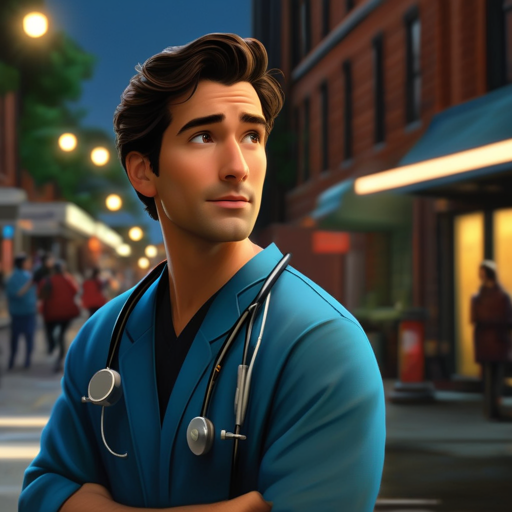

In [4]:
pipeline.set_ip_adapter_scale(0.8)

generator = torch.Generator(device="cuda").manual_seed(0)
images = pipeline(
    prompt="a doctor in blue scrubs in an emergency room",
    ip_adapter_image=style_image,
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=50,
    generator=generator,
).images
images[0].resize((512,512))

## Apply IP Adapter only to style layer
By default IP-Adapters are inserted to all layers of the model. This will often generate images that overly focus on image prompt and diminish diversity.

 Use the set_ip_adapter_scale() method with a dictionary to assign scales to IP-Adapter at different layers.

```python
scale = {
    "down": {"block_2": [0.0, 1.0]},
    "up": {"block_0": [0.0, 1.0, 0.0]},
}
```

This will activate IP-Adapter at the second layer in the model’s down-part block 2 and up-part block 0. The former is the layer where IP-Adapter injects layout information and the latter injects style. Inserting IP-Adapter to these two layers you can generate images following both the style and layout from image prompt, but with contents more aligned to text prompt.

Let's activate IP-Adapter only in the style layer and then call the pipeline again.



100%|██████████| 50/50 [00:06<00:00,  8.20it/s]


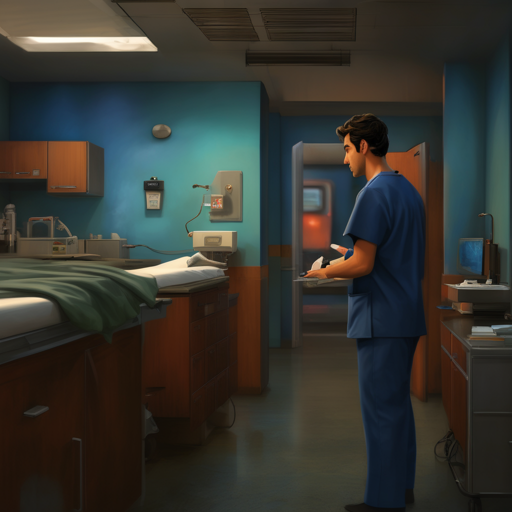

In [5]:
scale = {
    "up": {"block_0": [0.0, 1.0, 0.0]},
}

pipeline.set_ip_adapter_scale(scale)

generator = torch.Generator(device="cuda").manual_seed(26)

images = pipeline(
    prompt="a doctor in blue scrubs in an emergency room",
    ip_adapter_image=style_image,
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=50,
    generator=generator,
).images
images[0].resize((512,512))


### Using Ip Adapter with multiple images

IP Adapter can work with multiple images, in the following cells, we're loading 10 images of a similar style and are passing that to our pipeline.

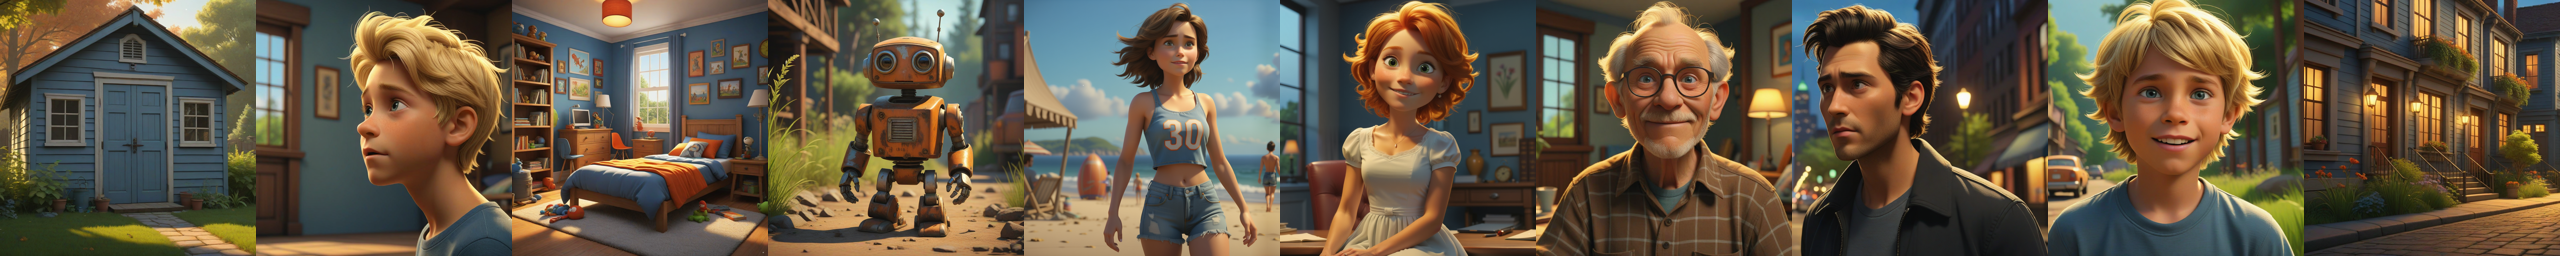

In [6]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

style_images = [load_image(f"{style_folder}/img{i}.png") for i in range(10)]

num_imgs_to_preview = 10
image_grid(style_images[:num_imgs_to_preview], 1, num_imgs_to_preview)

100%|██████████| 50/50 [00:07<00:00,  6.37it/s]


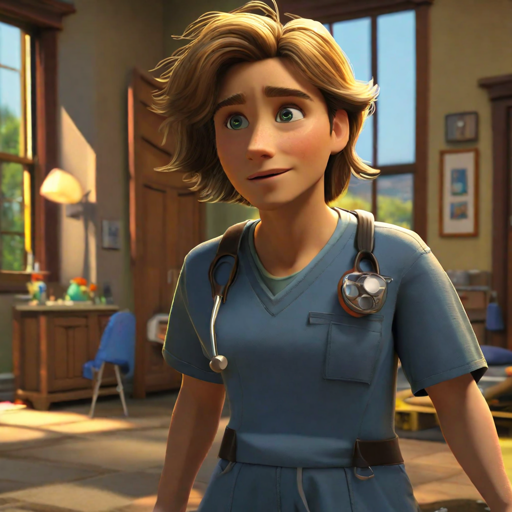

In [7]:
import torch
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name="ip-adapter-plus_sdxl_vit-h.safetensors"
)
#pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")


scale = {
    "up": {"block_0": [0.0, 1.0, 0.0]},
}
pipeline.set_ip_adapter_scale(0.8)
pipeline.enable_model_cpu_offload()

style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_images = [load_image(f"{style_folder}/img{i}.png") for i in range(10)]

generator = torch.Generator(device="cpu")

image = pipeline(
    prompt="a doctor in blue scrubs in an emergency room",
    ip_adapter_image=[style_images],
    negative_prompt="lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=50, 
    num_images_per_prompt=1,
    generator=generator,
).images[0]
image.resize((512,512))

## Conclusion

We were able to generate images using a text prompt and reference images, focusing specifically on replicating the style from the reference image.

There are more techniques to apply given styles to generated images, for example using LoRA fine tuning.